# Econ 323 Final Project

***Geographic effects on intergenerational income mobility in Spain***

# Background

The place where you are born can directly affect your life and your development in society. Both the household and the geographical area have been present in different analysis of individual income. Geography determines the economic growth and demographics of an area, which can have effects on the "inheritance" of income. With the recent progress of the Atlas of Opportunities of Spain, it may be interesting to analyze a region that has a particular demographic and geography. This study will analyze whether there is a relationship between geographical area and the intergenerational mobility of income.

# Literature Review

There are different studies about the intergenerational mobility of income, Miles Corak and Raj Chetty are remarkable economists in this area of study. In their studies, different aspects are found, such as quintile mobility, in which they use the Markov transition matrix together with variables that may affect this mobility, such as geographical area or characteristics of the parents. Corak directly analyzes effects such as the geographical area in which a transition between quintiles is most likely to occur (Moving from quintile 1 to quintile 5 is called the "Rag to Riches" and this can have different probabilities depending on the place)

# Hypothesis/Research

- Demographics:
Spain has a characteristic case in terms of its demography being the country with the lowest fertility rate in Europe, which poses various problems regarding the future of the Spanish labor market and derivatives.

- Geography:
Spain has a large region made up of exchange and agricultural land, its main cities are on the coasts with the exception of Madrid. It shares the same style of geography with France, you can see a diagonal line between Spain and France in which a low population density is displayed along the line.

- Economic mobility and coastal cities:
Coastal cities are main for economic development, they have historical importance because they were the main trading areas, this has an effect on the present
since, having a low birth rate, busy areas maintain a fixed population density and areas with low attendance in the same way, which has effects on economic mobility.

# Datasets and Analysis

All modules are imported for the creation of the datasets

In [1]:
from bs4 import BeautifulSoup
from folium.plugins import BeautifyIcon
from geopandas import GeoDataFrame
from linearmodels.iv.absorbing import AbsorbingLS, AbsorbingLSResults
from matplotlib.pyplot import figure
from os import remove
from os import rmdir
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
from sklearn import linear_model
from zipfile import ZipFile


import folium
import geopandas as gpd
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import shapely
import shutil
import statsmodels.api as sm
import string
import time
import warnings
import wget

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

The data is downloaded from GADM, which is a webpage that provides the map files of world regions

In [2]:
dir2="mapa1"
link2="https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_ESP_shp.zip"
 
try:
    shutil.rmtree(dir2)
except OSError as e:
     pass

os.mkdir(dir2)

req = requests.get(link2)
filename = link2.split('/')[-1]

with open("{}/{}".format(dir2,filename),'wb') as output_file:
    output_file.write(req.content)

with ZipFile("{}/{}".format(dir2,filename), 'r') as zip:
    zip.extractall(dir2) 
    
os.remove("{}/{}".format(dir2,filename))

To highlight the region with low population density, the data for France is also downloaded.

The Opportunity Atlas data is downloaded for its version in Spain

In [3]:
dir2="quintiles1"
link2="https://atlasoportunidades.fundacionfelipegonzalez.cotec.es/datos-atlas/datatset_atlas_oportunidad.zip"
 
try:
    shutil.rmtree(dir2)
except OSError as e:
     pass

os.mkdir(dir2)

req = requests.get(link2)
filename = link2.split('/')[-1]

with open("{}/{}".format(dir2,filename),'wb') as output_file:
    output_file.write(req.content)

with ZipFile("{}/{}".format(dir2,filename), 'r') as zip:
    zip.extractall(dir2) 
    
shutil.rmtree("{}/__MACOSX".format(dir2))
os.remove("{}/{}".format(dir2,filename))

r=[]
g=[]
n=0
for dirpath, dirnames, filenames in os.walk("quintiles1"):
    for x in filenames:
        g.append(str(n)+" - "+str(x))
        r.append(pd.read_csv("quintiles1/{}".format(str(x))))
        n+=1

Population density data for France

In [4]:
dir2="mapafrance"
link2="https://drive.google.com/u/0/uc?id=1TxWTzMGgheODN2hFJD4NPeGSw1PnvEwA&export=download"
 
try:
    shutil.rmtree(dir2)
except OSError as e:
     pass

os.mkdir(dir2)

req = requests.get(link2)
filename = link2.split('/')[-1]

with open("{}/popfrance.tsv".format(dir2),'wb') as output_file:
    output_file.write(req.content)

They work with the geographic data of France and join with the demographic data of the same region

In [5]:
france0=pd.read_csv("mapafrance/popfrance.tsv", sep='\t', thousands=',').iloc[3:100,:]

new_header = france0.iloc[0] #Get the first row for the header
france0 = france0[1:] #Take the data less the header row
france0.columns = new_header #Set the header row as the df header
france0.columns = np.arange(len(france0.columns))
france=pd.DataFrame(france0[[0,1,7]])
france.rename(columns={france0.columns[0]: "depcode",france0.columns[1]: "NAME_2",france0.columns[7]: "t_total"}, inplace = True)

neighborhoods2 = gpd.read_file('mapa2/gadm36_FRA_2.shp',encoding="utf-8")
france2 = neighborhoods2.merge(france)
france2

def coma(x):
    lista1=[]
    for i in x:
        if i != ",":
            lista1.append(i)
    return float("".join(lista1))

france2["t_total2"]=france2["t_total"].apply(lambda x: coma(x))

colores=list(reversed(["#4f0000","#540402",
"#590904","#5f0e06","#641308","#691809","#6e1d0a",
"#73210b","#78260b","#7d2b0b","#822f0b","#87340b",
"#8c390a","#913e0a","#964309","#9a4808","#9f4d07",
"#a35206","#a75705","#ac5c03","#b06202","#b46700",
"#b86d00","#bb7200","#bf7800","#c37d00","#c68300",
"#c98900","#cc8f00","#cf9400","#d29a00","#d5a000",
"#d7a600","#daac00","#dcb300","#deb900","#e0bf00",
"#e2c500","#e4cc00","#e5d200"]))

bins=np.linspace(min(france2["t_total2"].apply(lambda x: float(x))),max(france2['t_total2'].apply(lambda x: float(x))),len(colores)+1)
france2['color']=pd.cut(france2['t_total2'],bins,labels=colores,include_lowest=True)


The same process is realized with Spain data.

In [6]:
neighborhoods = gpd.read_file('mapa1/gadm36_ESP_1.shp',encoding="utf-8")

url = 'https://datosmacro.expansion.com/demografia/poblacion/espana-comunidades-autonomas?anio=2020'
pagina = requests.get(url)
soup = BeautifulSoup(pagina.content, 'html.parser')

tbl = soup.find("table",{"id":"tb1"})

df = pd.read_html(str(tbl))[0]
df = df[['CCAA', 'Densidad']]
df.head()

df.CCAA.unique()
neighborhoods.NAME_1.unique()

df['CCAA'] = df['CCAA'].map(lambda x: x.replace(' [+]', ''))

def cambio(x):
    if x=="Castilla-La Mancha":
        return "Castilla La Mancha"
    if x=="Comunidad de Madrid":
        return "Madrid"
    if x=="Región de Murcia":
        return "Murcia"
    else:
        return x
    
df["CCAA"] = df["CCAA"].apply(lambda x: cambio(x))

espania=neighborhoods
espania['NAME_1'] = np.where(espania['NAME_1']=='Castilla-La Mancha','Castilla La Mancha',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Comunidad Foral de Navarra','Navarra',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Ceuta y Melilla','Ceuta',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Islas Canarias','Canarias',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Región de Murcia','Murcia',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Comunidad de Madrid','Madrid',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Islas Canarias','Canarias',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Principado de Asturias','Asturias',espania['NAME_1'])

espania = espania.merge(df, left_on=['NAME_1'],right_on=['CCAA'], how='left')

colores=list(reversed(["#4f0000","#540402",
"#590904","#5f0e06","#641308","#691809","#6e1d0a",
"#73210b","#78260b","#7d2b0b","#822f0b","#87340b",
"#8c390a","#913e0a","#964309","#9a4808","#9f4d07",
"#a35206","#a75705","#ac5c03","#b06202","#b46700",
"#b86d00","#bb7200","#bf7800","#c37d00","#c68300",
"#c98900","#cc8f00","#cf9400","#d29a00","#d5a000",
"#d7a600","#daac00","#dcb300","#deb900","#e0bf00",
"#e2c500","#e4cc00","#e5d200"]))

bins=np.linspace(min(espania["Densidad"].apply(lambda x: float(x))),max(espania['Densidad'].apply(lambda x: float(x))),len(colores)+1)
espania['color']=pd.cut(espania['Densidad'],bins,labels=colores,include_lowest=True)

The heat map is made for the Spanish region at the autonomous community level. It is visualized that there is a higher population density on the coasts, however the difference with Madrid means that the contrast between the regions is not well visualized.

In [7]:
mapa0 = folium.Map(location=[40, -3], zoom_start=5, tiles="Cartodb Positron")

def heatmap(x):
    for _, ñ in espania.iloc[x:x+1,:].iterrows():
        sim_geo = gpd.GeoSeries(ñ['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'fillColor': ñ["color"],"color":"black","weight": 0.5,"fillOpacity":1})
        folium.Popup(ñ["NAME_1"]).add_to(geo_j)
        geo_j.add_to(mapa0)

for x in range(espania.shape[0]):
    heatmap(x)
    
mapa0

To solve this problem, a heat map is made for all regions except Madrid and at the end the capital region is added. The coastal effect on demographics becomes more evident.

In [8]:
mapa = folium.Map(location=[40, -3], zoom_start=5, tiles="Cartodb Positron")

espania2=espania.loc[espania["NAME_1"]!="Madrid"].drop(["color"], axis=1)
bins2=np.linspace(min(espania2["Densidad"].apply(lambda x: float(x))),max(espania2['Densidad'].apply(lambda x: float(x))),len(colores)+1)
espania2['color']=pd.cut(espania2['Densidad'],bins2,labels=colores,include_lowest=True)
def heatmap(x):
    for _, ñ in espania2.iloc[x:x+1,:].iterrows():
        sim_geo = gpd.GeoSeries(ñ['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'fillColor': ñ["color"],"color":"black","weight": 0.5,"fillOpacity":1})
        folium.Popup(ñ["NAME_1"]).add_to(geo_j)
        geo_j.add_to(mapa)

for x in range(espania2.shape[0]):
    heatmap(x)
    
espania3=espania.loc[espania["NAME_1"]=="Madrid"]
for _, ñ in espania3.iloc[0:1,:].iterrows():
    sim_geo = gpd.GeoSeries(ñ['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'fillColor': "#581845","color":"black","weight": 0.5,"fillOpacity":1})
    folium.Popup(ñ["NAME_1"]).add_to(geo_j)
    geo_j.add_to(mapa)
    
mapa

The French region is added with the same process, it is evident that the coastal effect also expands in France.

In [9]:
def heatmap2(x):
    for _, ñ in france2.iloc[x:x+1,:].iterrows():
        sim_geo = gpd.GeoSeries(ñ['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'fillColor': ñ["color"],"color":"black","weight": 0.5,"fillOpacity":1})
        folium.Popup(ñ["NAME_2"]).add_to(geo_j)
        geo_j.add_to(mapa)

for x in range(france2.shape[0]):
    heatmap2(x)

mapa



To emphasize the region with low population density, a line is made in the study area.

In [10]:
coordinates =[[39.7, -6], [41, -1.8], [43.6, 0.55], [47.2, 3.5], [49.7, 4.8]]

my_PolyLine=folium.PolyLine(locations=coordinates,weight=5,color="black")
mapa.add_child(my_PolyLine)

In light of seeing a coastal effect on demographics, it's time to see if it translates to the data. The data of the income centiles of the parents in relation to the children are available.

An OLS regression is made having as dependent variable the percentile of the children, independent of the percentile of the parents and different control variables such as the autonomous community where they live, the sex of the child, the type of expense that is analyzed, and so on. Significance is found in all variables. Analyzing specifically the variables of the autonomous communities, it can be seen that in most cases, living in an area with a higher population density affects the change in the centiles.

In [11]:
data1_1=r[2].loc[r[2]["promedio"]=="media"]
data1_2=data1_1.sort_values(by=['ccaa', 'centil_padres'])
data1_3=pd.concat([data1_2, pd.get_dummies(data1_2[["sexo","tipo_renta","ccaa"]])], axis=1)
lista1=list(pd.get_dummies(data1_2[["sexo","tipo_renta","ccaa"]]).columns)
lista2=["centil_padres","n"]

X = data1_3[lista2+lista1] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = data1_3['centil_hijo']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            centil_hijo   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     2062.
Date:                Mon, 26 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:12:16   Log-Likelihood:                -21392.
No. Observations:                9000   AIC:                         4.282e+04
Df Residuals:                    8980   BIC:                         4.297e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In light of seeing a coastal effect on demographics, it's time to see if it translates to the data.
The data of the income centiles of the parents in relation to the children are available.

However, this regression may be biased because there may be omitted variables in
the error term that cannot be observed such as the intelligence of the child, spending on studies, and so on

To do this, a fixed effects model is made in order to eliminate this possible bias.

The instrumental variable used is population density as a possible effect on the percentile of parents, and fixed effects are performed based on the area. To reduce the measurement error, we work with provinces and thus have much more data.

A two-stage regression is performed, the first regression is the population density on the percentile of the parents, and then it is the regression of the parents on the children.

In [12]:
from linearmodels.iv.absorbing import AbsorbingLS, AbsorbingLSResults

data1_1 = r[3].loc[r[3]["promedio"]=="media"]
data1_2 = data1_1.sort_values(by=['cp', 'centil_padres'])
data1_3 = pd.concat([data1_2, pd.get_dummies(data1_2[["sexo","tipo_renta"]])], axis=1)
data1_4 = data1_3.reset_index(drop=True)
data1_5 = data1_4.loc[data1_4["centil_hijo"].isna()==False]

suma = data1_5[["cp","n_total"]].groupby(['cp']).sum("n_total").reset_index(level=0)
result = pd.merge(data1_5, suma, on="cp")
result["n2"]=result["n_total_x"]/result["n_total_y"]

X = result[["n2","n_total_x","n_total_y"]] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = result['centil_padres']

mod = AbsorbingLS(Y,X,absorb=(pd.DataFrame(result["cp"].apply(lambda x: float(x)))))
print(mod.fit())

                         Absorbing LS Estimation Summary                          
Dep. Variable:          centil_padres   R-squared:                          0.7364
Estimator:               Absorbing LS   Adj. R-squared:                     0.7364
No. Observations:             2176548   F-statistic:                     1.368e+06
Date:                Mon, Jun 26 2023   P-value (F-stat):                   0.0000
Time:                        17:12:24   Distribution:                      chi2(3)
Cov. Estimator:                robust   R-squared (No Effects):             0.3879
                                        Varaibles Absorbed:                 1.0000
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
n2          2.681e+04     26.225     1022.5     0.0000   2.676e+04   2.687e+04
n_total_x     -0.045

It is found that with the two-stage regression, the sample is equally significant. However, we are more certain that there is less bias. With the analyzed sample, it can be affirmed that there is an effect of population density on the percentile of children and therefore on income.

In [13]:
result["pred"]=mod.fit().fitted_values
result["error"]=result["pred"]-result["centil_padres"]

X2=result[["pred","sexo_mujer","sexo_hombre","tipo_renta_hogar","error"]]
Y2=result["centil_hijo"]
mod2 = AbsorbingLS(Y2,X2,absorb=(pd.DataFrame(result["cp"].apply(lambda x: float(x)))))
print(mod2.fit())

                         Absorbing LS Estimation Summary                          
Dep. Variable:            centil_hijo   R-squared:                          0.9705
Estimator:               Absorbing LS   Adj. R-squared:                     0.9705
No. Observations:             2176548   F-statistic:                     1.609e+07
Date:                Mon, Jun 26 2023   P-value (F-stat):                   0.0000
Time:                        17:12:30   Distribution:                      chi2(5)
Cov. Estimator:                robust   R-squared (No Effects):             0.8893
                                        Varaibles Absorbed:                 1.0000
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
pred                 0.9002     0.0003     3129.7     0.0000      0.8997      0.9

For further analysis in terms of quintile mobility, it is recommended to perform a probit or logit model, however it is a more advanced procedure. For a simple analysis, the quintile mobility can be visualized with a stacked bar chart obtained from the Markov mobility matrices. 

At first glance, it can be seen that the effect is not significant in terms of the difference in these matrices. But when applied in the map we were using before, we can see that the effect may vary if we analize the northern parts or the southern parts. But either way, the geographic effect is different of the effect that we are studying.

The maps in the end show the following:

- First Map: Probability to stay in the first quintile
- Second Map: Probability to pass from the first quintile to the fifth quintile
- Third Map: Probability to stay in the first quintile

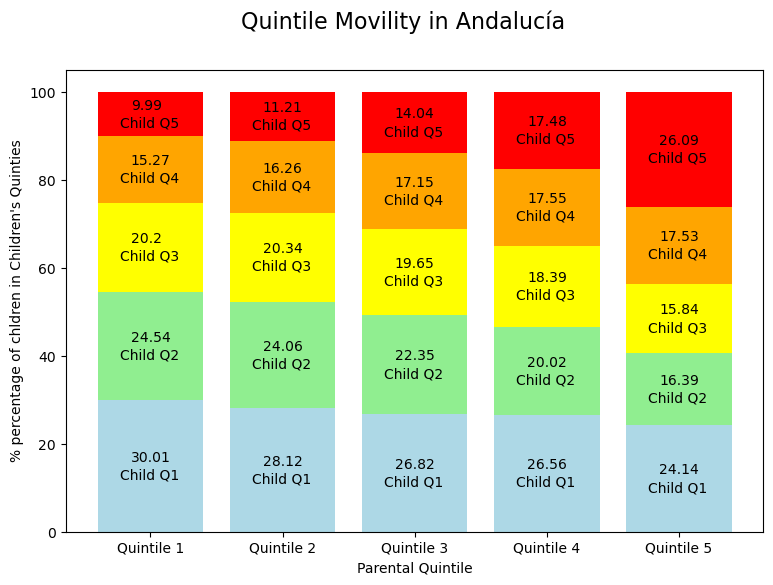

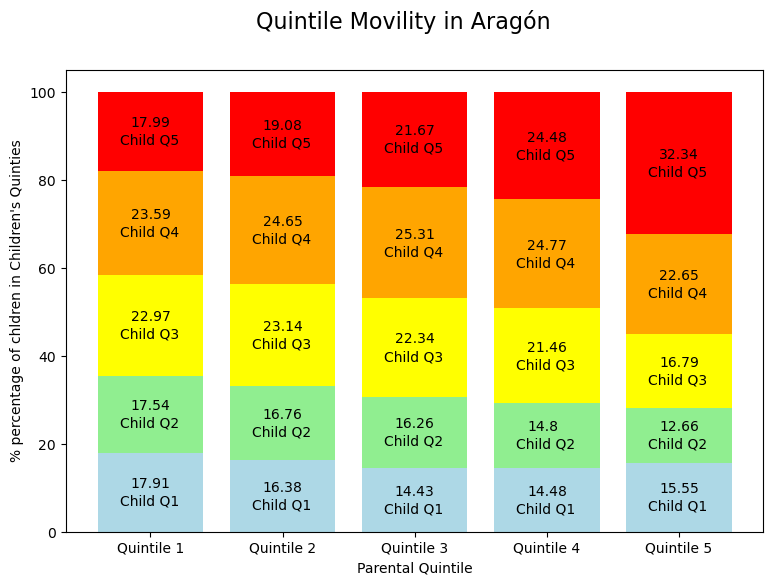

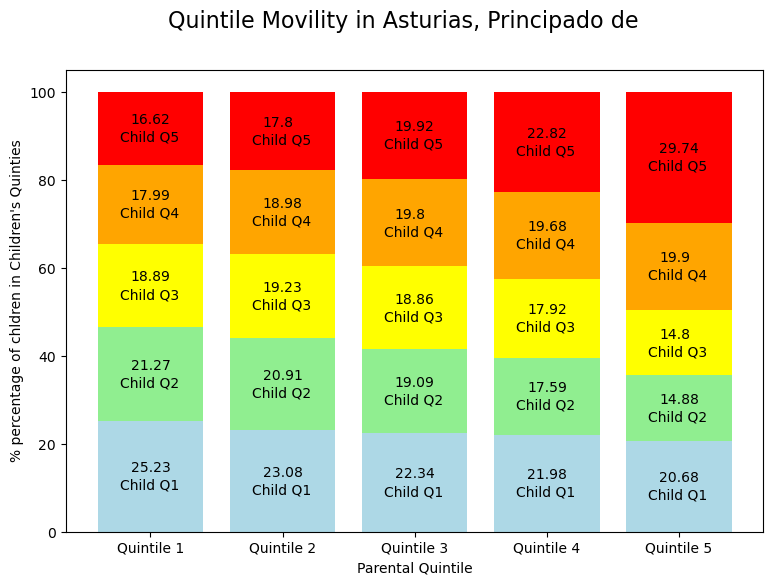

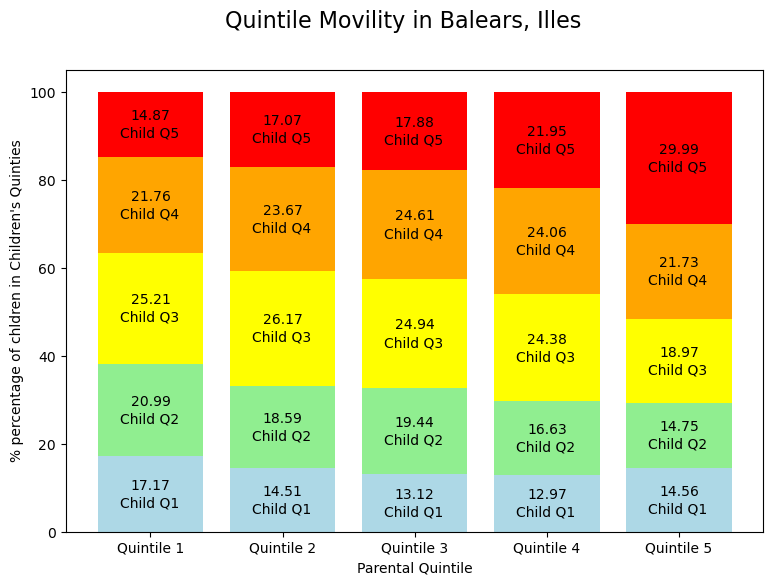

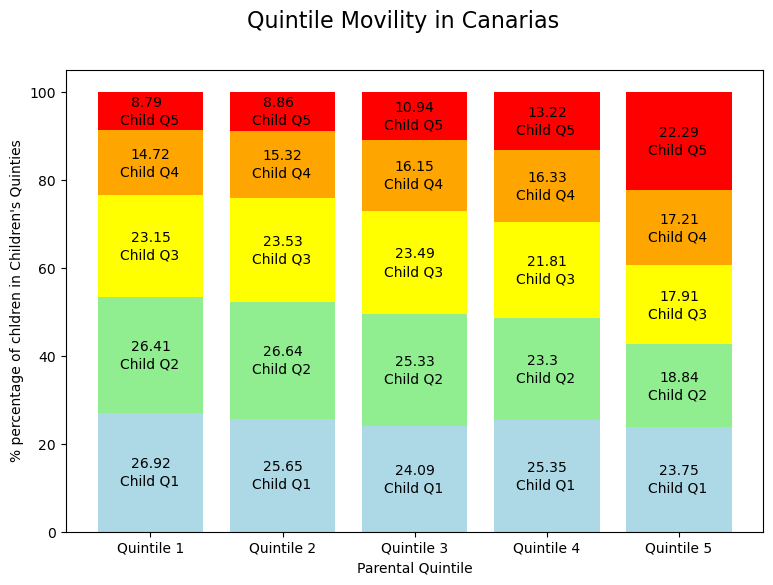

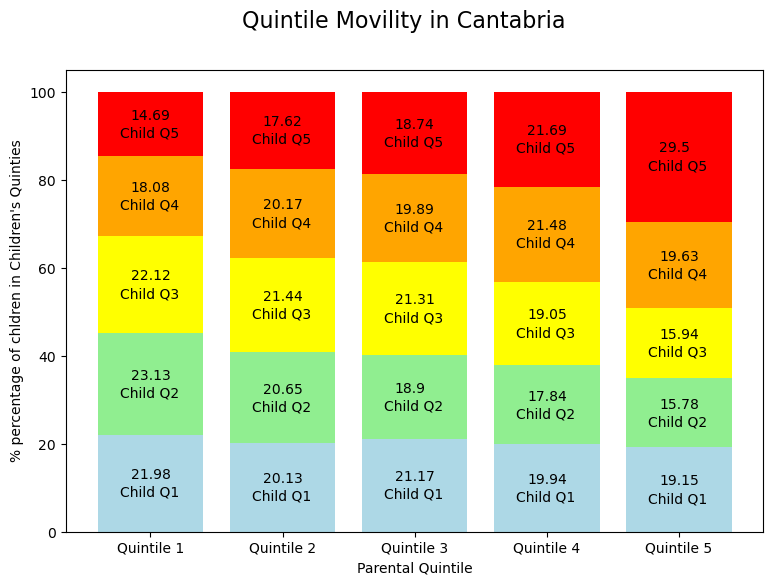

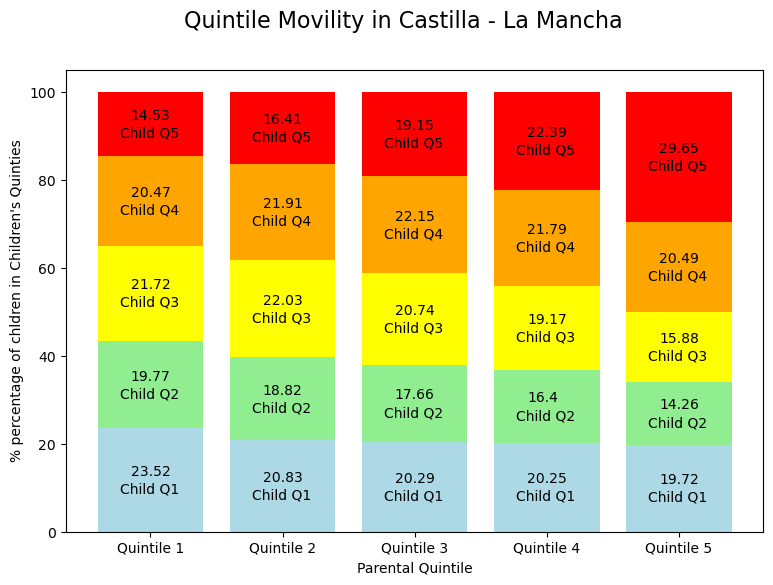

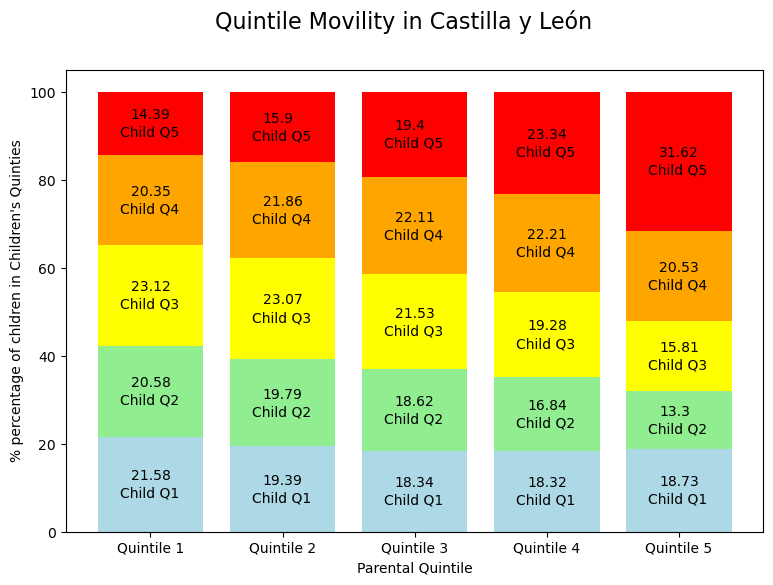

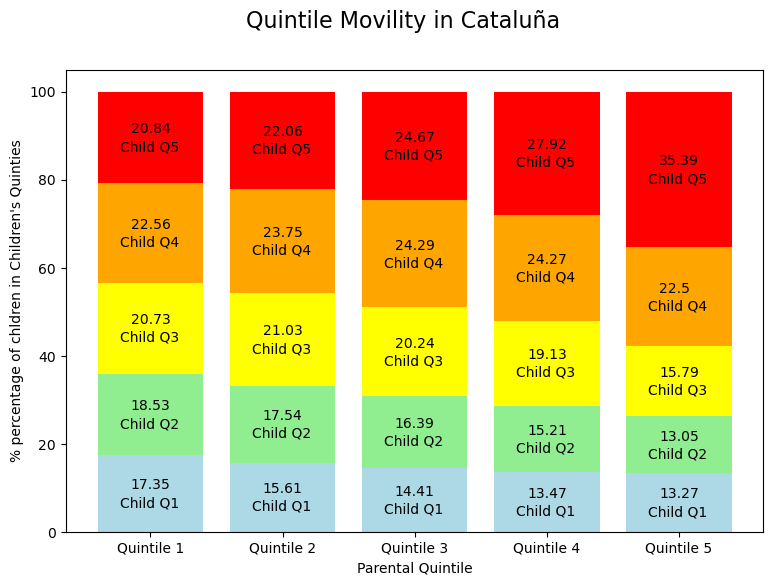

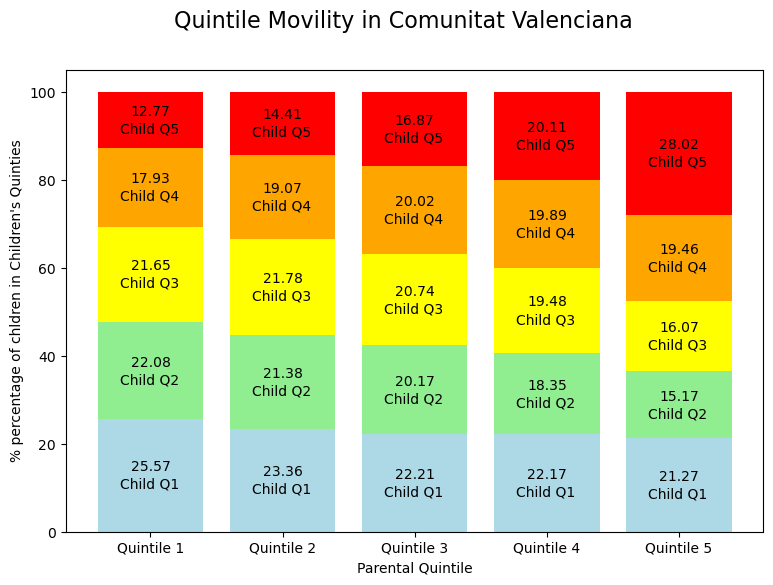

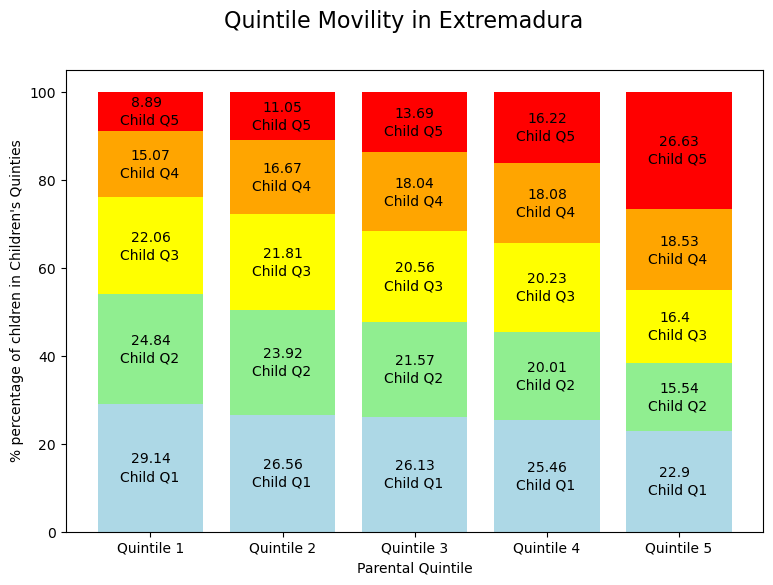

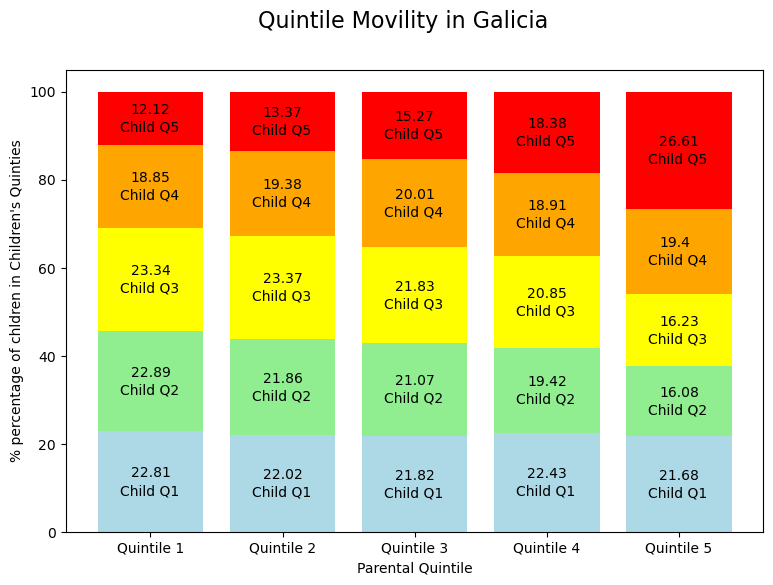

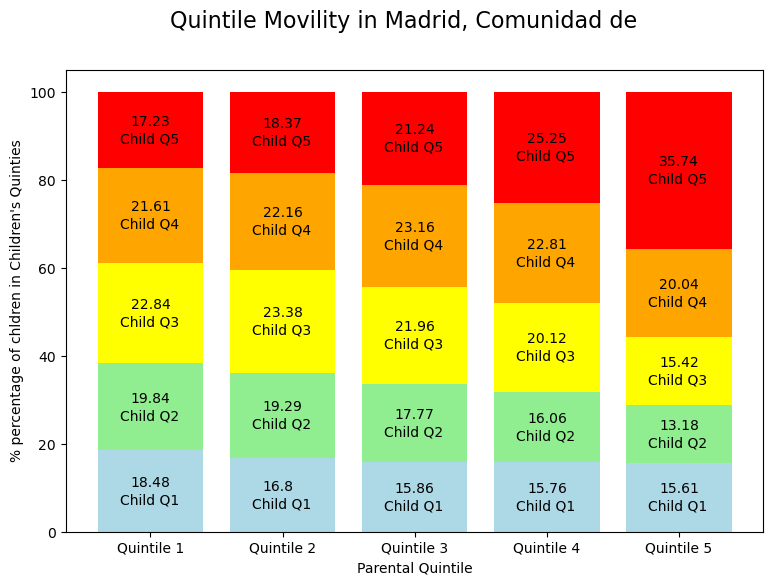

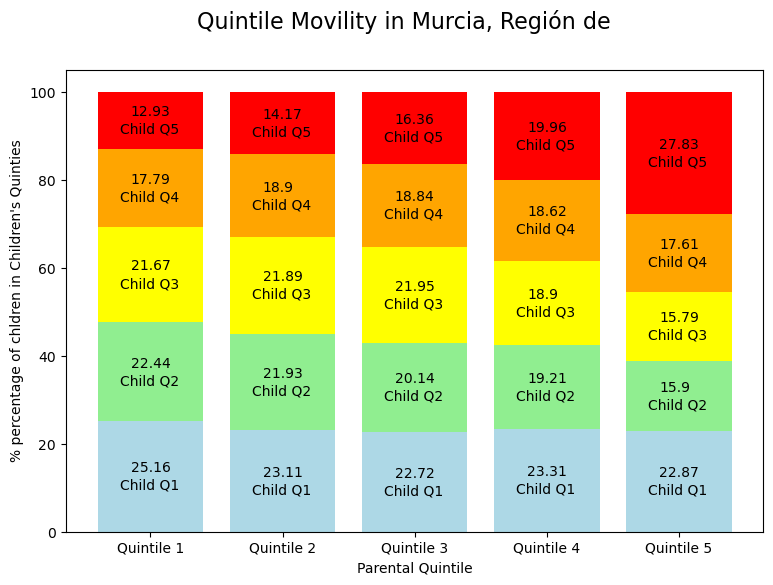

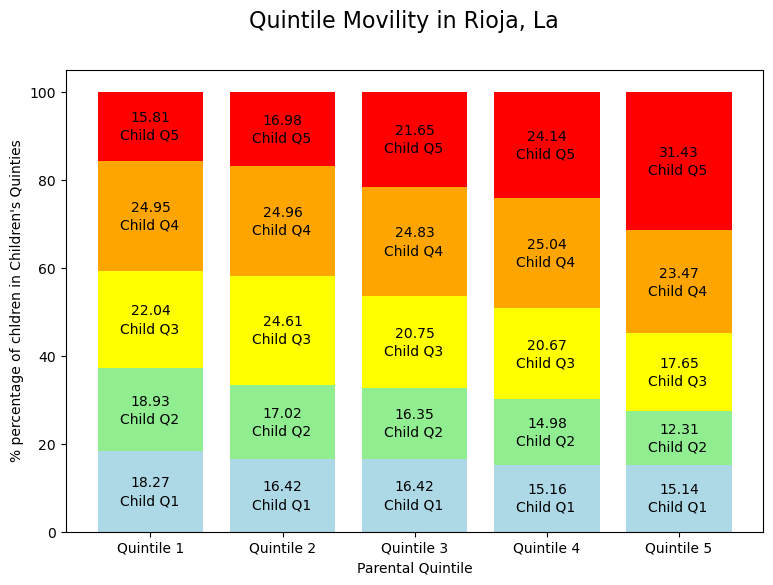

In [14]:
def quintil(CA):
    a=r[8]
    a2=a.loc[a["sexo"]=="total"]
    a3=a2.loc[a2["tipo_renta"]=="hogar"]
    a4=a3.sort_values(by=["quintil_hijo","quintil_padres"])
    a5=a4.loc[a4["ccaa"]==CA]

    lista2=[]
    for x in list(a5.value_counts("quintil_padres").index):
        lista2.append(list(a5.loc[a5["quintil_hijo"]==x]["pc"]))

    figure(figsize=(9,6))

    x = ['Quintile 1', 'Quintile 2', 'Quintile 3', 'Quintile 4', 'Quintile 5']
    A = np.round(np.array(lista2[0]),4)
    B = np.round(np.array(lista2[1]),4)
    C = np.round(np.array(lista2[2]),4)
    D = np.round(np.array(lista2[3]),4)
    E = np.round(np.array(lista2[4]),4)

    plt.bar(x, A, color='lightblue')
    plt.bar(x, B, bottom=A, color='lightgreen')
    plt.bar(x, C, bottom=A+B, color='yellow')
    plt.bar(x, D, bottom=A+B+C, color='orange')
    plt.bar(x, E, bottom=A+B+C+D, color='red')

    plt.xlabel("Parental Quintile")
    plt.ylabel("% percentage of chldren in Children's Quinties")

    df1 = {'Quintile 1':np.array(lista2[0]), 'Quintile 2':np.array(lista2[1]), 'Quintile 3':np.array(lista2[2]), 'Quintile 4':np.array(lista2[3]), 'Quintile 5':np.array(lista2[4])}
    df2 = pd.DataFrame(data=df1).applymap(lambda x: round(x,2))

    A0=np.array(df2.T[0])
    B0=np.array(df2.T[1])
    C0=np.array(df2.T[2])
    D0=np.array(df2.T[3])
    E0=np.array(df2.T[4])

    def addlabel(A,param):
        for x in range(5):
            lista_params=list(A)[:x+1]
            param2=sum(lista_params[:-1]+[lista_params[-1]/2])
            plt.text(param, param2+1, A[x])
            plt.text(param-0.08, param2-3,"Child Q{}".format(x+1))

    addlabel(A0,-0.15)
    addlabel(B0,0.85)
    addlabel(C0,1.85)
    addlabel(D0,2.85)
    addlabel(E0,3.85)

    plt.suptitle('Quintile Movility in {}'.format(CA), fontsize=16)
     
for x in list(r[8]["ccaa"].value_counts().index):
     quintil(x)

In [15]:
def cambio2(x):
    if x == "Asturias, Principado de":
        return "Asturias"
    elif x == "Castilla - La Mancha":
        return "Castilla La Mancha"
    elif x== "Balears, Illes":
        return "Islas Baleares"
    elif x == "Comunitat Valenciana":
        return "Comunidad Valenciana"
    elif x == "Madrid, Comunidad de":
        return "Madrid"
    elif x == "Murcia, Región de":
        return "Murcia"
    elif x == "Rioja, La":
        return "La rioja"
    else:
        return x
    
a=r[8]
a2=a.loc[a["sexo"]=="total"]
a3=a2.loc[a2["tipo_renta"]=="hogar"]
a4=a3.sort_values(by=["ccaa","quintil_padres","quintil_hijo"]).copy()
a4["CCAA"]=a4["ccaa"].apply(lambda x: cambio2(x))
a4["mob"]=a4["quintil_padres"]+"/"+a4["quintil_hijo"]
a6=a4.loc[a4["mob"]=="0-20/0-20"]

espania2 = espania.copy()
espania2 = espania2.merge(a6[["CCAA","pc","n"]], on=["CCAA"], how='left')
espania2.drop(columns=["color"])
espania2=espania2.loc[espania2["pc"].isna()==False]
colores=list(reversed(["#4f0000","#540402",
"#590904","#5f0e06","#641308","#691809","#6e1d0a",
"#73210b","#78260b","#7d2b0b","#822f0b","#87340b",
"#8c390a","#913e0a","#964309","#9a4808","#9f4d07",
"#a35206","#a75705","#ac5c03","#b06202","#b46700",
"#b86d00","#bb7200","#bf7800","#c37d00","#c68300",
"#c98900","#cc8f00","#cf9400","#d29a00","#d5a000",
"#d7a600","#daac00","#dcb300","#deb900","#e0bf00",
"#e2c500","#e4cc00","#e5d200"]))

bins=np.linspace(min(espania2["pc"].apply(lambda x: float(x))),max(espania2['pc'].apply(lambda x: float(x))),len(colores)+1)
espania2['color']=pd.cut(espania2['pc'],bins,labels=colores,include_lowest=True)

mapa0 = folium.Map(location=[40, -3], zoom_start=5, tiles="Cartodb Positron")

def heatmap(x):
    for _, ñ in espania2.iloc[x:x+1,:].iterrows():
        sim_geo = gpd.GeoSeries(ñ['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'fillColor': ñ["color"],"color":"black","weight": 0.5,"fillOpacity":1})
        folium.Popup("{} \n {}".format(ñ["NAME_1"],round(ñ["pc"],3))).add_to(geo_j)
        geo_j.add_to(mapa0)

for x in range(espania.shape[0]):
    heatmap(x)

mapa0.add_child(folium.Marker(location=(42.510018, -18),
                    icon=folium.DivIcon(html="<b style='color: #000000;font-size: 12px;'> {} </b>".format(str("MAP 1: Probablity to stay in the 1st Quintile")),
                                          class_name="mapText")))
mapa0



In [16]:
def cambio2(x):
    if x == "Asturias, Principado de":
        return "Asturias"
    elif x == "Castilla - La Mancha":
        return "Castilla La Mancha"
    elif x== "Balears, Illes":
        return "Islas Baleares"
    elif x == "Comunitat Valenciana":
        return "Comunidad Valenciana"
    elif x == "Madrid, Comunidad de":
        return "Madrid"
    elif x == "Murcia, Región de":
        return "Murcia"
    elif x == "Rioja, La":
        return "La rioja"
    else:
        return x
    
a=r[8]
a2=a.loc[a["sexo"]=="total"]
a3=a2.loc[a2["tipo_renta"]=="hogar"]
a4=a3.sort_values(by=["ccaa","quintil_padres","quintil_hijo"]).copy()
a4["CCAA"]=a4["ccaa"].apply(lambda x: cambio2(x))
a4["mob"]=a4["quintil_padres"]+"/"+a4["quintil_hijo"]
a6=a4.loc[a4["mob"]=="0-20/80-100"]

espania2 = espania.copy()
espania2 = espania2.merge(a6[["CCAA","pc","n"]], on=["CCAA"], how='left')
espania2.drop(columns=["color"])
espania2=espania2.loc[espania2["pc"].isna()==False]
colores=list(reversed(["#4f0000","#540402",
"#590904","#5f0e06","#641308","#691809","#6e1d0a",
"#73210b","#78260b","#7d2b0b","#822f0b","#87340b",
"#8c390a","#913e0a","#964309","#9a4808","#9f4d07",
"#a35206","#a75705","#ac5c03","#b06202","#b46700",
"#b86d00","#bb7200","#bf7800","#c37d00","#c68300",
"#c98900","#cc8f00","#cf9400","#d29a00","#d5a000",
"#d7a600","#daac00","#dcb300","#deb900","#e0bf00",
"#e2c500","#e4cc00","#e5d200"]))

bins=np.linspace(min(espania2["pc"].apply(lambda x: float(x))),max(espania2['pc'].apply(lambda x: float(x))),len(colores)+1)
espania2['color']=pd.cut(espania2['pc'],bins,labels=colores,include_lowest=True)

mapa0 = folium.Map(location=[40, -3], zoom_start=5, tiles="Cartodb Positron")

def heatmap(x):
    for _, ñ in espania2.iloc[x:x+1,:].iterrows():
        sim_geo = gpd.GeoSeries(ñ['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'fillColor': ñ["color"],"color":"black","weight": 0.5,"fillOpacity":1})
        folium.Popup("{} \n {}".format(ñ["NAME_1"],round(ñ["pc"],3))).add_to(geo_j)
        geo_j.add_to(mapa0)

for x in range(espania.shape[0]):
    heatmap(x)
    
mapa0.add_child(folium.Marker(location=(42.510018, -18),
                    icon=folium.DivIcon(html="<b style='color: #000000;font-size: 12px;'> {} </b>".format(str("MAP 2: Probablity to pass from the 1st to 5th quintile")),
                                          class_name="mapText")))
mapa0

In [17]:
def cambio2(x):
    if x == "Asturias, Principado de":
        return "Asturias"
    elif x == "Castilla - La Mancha":
        return "Castilla La Mancha"
    elif x== "Balears, Illes":
        return "Islas Baleares"
    elif x == "Comunitat Valenciana":
        return "Comunidad Valenciana"
    elif x == "Madrid, Comunidad de":
        return "Madrid"
    elif x == "Murcia, Región de":
        return "Murcia"
    elif x == "Rioja, La":
        return "La rioja"
    else:
        return x
    
a=r[8]
a2=a.loc[a["sexo"]=="total"]
a3=a2.loc[a2["tipo_renta"]=="hogar"]
a4=a3.sort_values(by=["ccaa","quintil_padres","quintil_hijo"]).copy()
a4["CCAA"]=a4["ccaa"].apply(lambda x: cambio2(x))
a4["mob"]=a4["quintil_padres"]+"/"+a4["quintil_hijo"]
a6=a4.loc[a4["mob"]=="80-100/80-100"]

espania2 = espania.copy()
espania2 = espania2.merge(a6[["CCAA","pc","n"]], on=["CCAA"], how='left')
espania2.drop(columns=["color"])
espania2=espania2.loc[espania2["pc"].isna()==False]
colores=list(reversed(["#4f0000","#540402",
"#590904","#5f0e06","#641308","#691809","#6e1d0a",
"#73210b","#78260b","#7d2b0b","#822f0b","#87340b",
"#8c390a","#913e0a","#964309","#9a4808","#9f4d07",
"#a35206","#a75705","#ac5c03","#b06202","#b46700",
"#b86d00","#bb7200","#bf7800","#c37d00","#c68300",
"#c98900","#cc8f00","#cf9400","#d29a00","#d5a000",
"#d7a600","#daac00","#dcb300","#deb900","#e0bf00",
"#e2c500","#e4cc00","#e5d200"]))

bins=np.linspace(min(espania2["pc"].apply(lambda x: float(x))),max(espania2['pc'].apply(lambda x: float(x))),len(colores)+1)
espania2['color']=pd.cut(espania2['pc'],bins,labels=colores,include_lowest=True)

mapa0 = folium.Map(location=[40, -3], zoom_start=5, tiles="Cartodb Positron")

def heatmap(x):
    for _, ñ in espania2.iloc[x:x+1,:].iterrows():
        sim_geo = gpd.GeoSeries(ñ['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'fillColor': ñ["color"],"color":"black","weight": 0.5,"fillOpacity":1})
        folium.Popup("{} \n {}".format(ñ["NAME_1"],round(ñ["pc"],3))).add_to(geo_j)
        geo_j.add_to(mapa0)

for x in range(espania.shape[0]):
    heatmap(x)
    
mapa0.add_child(folium.Marker(location=(42.510018, -18),
                    icon=folium.DivIcon(html="<b style='color: #000000;font-size: 12px;'> {} </b>".format(str("MAP 3: Probablity to stay in the 5th Quintile")),
                                          class_name="mapText")))
mapa0

# Conclusions

It can be affirmed that there is an effect of density on the income of children, which is related to historical background and both demographic and geographic problems in the region.

The birth problem can directly affect this problem, since it limits economic growth in less crowded regions, which can finally be reflected in the contrast of the income of different areas.


# Limitations

The lack of variables can be a big problem when performing the analyses, since there may be different effects that are not being considered in the main variables, as well as biases in these.

***Regressions performed with centiles***

***Omitted variables***


The regressions could also show a bias due to the fact that only the data of centiles are being used, for a greater analysis, a union of the data of converters could be carried out and the regressions with the incomes could be carried out directly, but for the geographic analysis it is not possible use these converters.

***Missing Data***

For the analysis of autonomous communities, the data of some communities are not found, which makes the geographical study of the country difficult. The maps could have been merged, but the different names and missing data made it difficult.

# References

- Martínez, M., Intralawan, A., Vázquez, G., Pérez-Maqueo, O., Sutton, P., & Landgrave, R. (2007). The coasts of our world: Ecological, economic and social importance. Ecological Economics, 63(2–3), 254–272. https://doi.org/10.1016/j.ecolecon.2006.10.022
- Wolff, Professor of Economics Edward N. (2008). Poverty and Income Distribution (2nd ed.).
Wiley-Blackwell. https://doi.org/10.25071/1874-6322.30581
- Cambaud, L. (2021, 24 octubre). En Foco - El problema demográfico en España, el país europeo con más bajo índice de fecundidad. Cambaud, Laura. https://www.france24.com/es/programas/en-foco/20211024-demografia-espana-natalidad-pensiones-inmigracion
- Buck Consultants International. (2009). LA EVOLUCIÓN DEL PAPEL DE LOS PUERTOS MARÍTIMOS EN EL ÁMBITO DE LA LOGÍSTICA MARÍTIMA MUNDIAL (Revisado ed.). Parlamento Europeo.
- Corak, M. (2017). "Divided Landscapes of Economic Opportunity: The Canadian Geography of Intergenerational Income Mobility," Working Papers 2017-043, Human Capital and Economic Opportunity Working Group.